## Neural Network 구현
* 1개의 hidden layer가 있는 2-class classification neural network 
* cross entropy loss 활용
* forward/backward propagation 구현

### 환경 구성
* coursera 강의에서 제공하는 planar_utils.py 사용

In [64]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from testCases_v2 import *
from public_tests import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets


#print 함수 없이 출력
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'
#주피터 화면 확장
from IPython.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 데이터셋 로딩
* shape 정보 확인 
* 시각화

In [16]:
# 2개의 feature를 가지고 있는 X, Y는 0 또는 1
# 총 400개의 training sample (m)
X, Y = load_planar_dataset()
X.shape
Y.shape

(2, 400)

(1, 400)

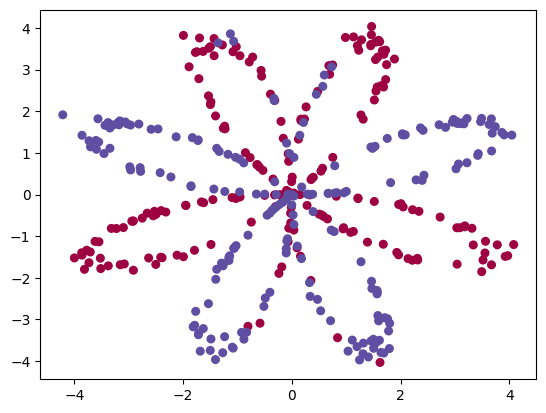

In [17]:
# scatter plot으로 데이터 확인, y=0: 빨간색, y=1: 파란색
plt.scatter(X[0, :], X[1, :], c=Y, s=30, cmap=plt.cm.Spectral);

### 간단한 logistic regression 모델 생성 
* sklearn의 LogisticRegressionCV (교차검증이 포함되어 있는 모델)

In [44]:
# 모델생성
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T)

C:\dev\workspace\venvs\ml_py37\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegressionCV()

Text(0.5, 1.0, 'Logistic Regression')

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


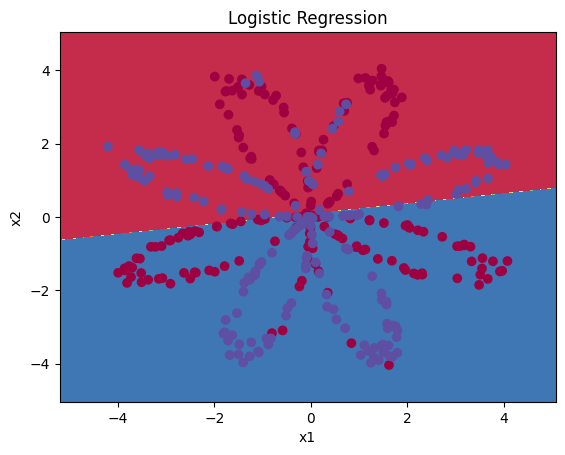

In [47]:
# logistic regression 모델 구분선 기준으로 1로 예측한 영역, 0으로 예측한 영역 표시
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# 정확도 출력
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

### Neural Network 모델 생성
* 1개의 hidden layer가 있는 neural network 모델 생성

* For one example $x^{(i)}$:
    + $z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}$ 
    + $a^{[1] (i)} = \tanh(z^{[1] (i)})$
    + $z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}$
    + $\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})$
    + $y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}$

* cost $J$ as follows: 
    + $J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small $

In [51]:
# 각 layer의 노드 수 출력 (hidden layer 노드 수는 4로 가정)
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    
    return (n_x, n_h, n_y)

In [56]:
np.random.rand(4, 2).shape

(4, 2)

#### parameter 초기화

In [67]:
# parameter 초기화
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """    
    # 작은 값으로 초기화하기 위해 0.01 곱함 
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y,1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [71]:
# test
np.random.seed(2)
n_x, n_h, n_y = initialize_parameters_test_case()
parameters = initialize_parameters(n_x, n_h, n_y)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

# initialize_parameters_test(initialize_parameters)

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


#### Forward Propagation
* $Z^{[1]} =  W^{[1]} X + b^{[1]}$ 
* $A^{[1]} = \tanh(Z^{[1]})$
* $Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$
* $\hat{Y} = A^{[2]} = \sigma(Z^{[2]})$

In [81]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """ 
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    # A2 shape이 (1,m) 이 맞는지 확인 
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [82]:
t_X, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(t_X, parameters)
print("A2 = " + str(A2))

# forward_propagation_test(forward_propagation)

A2 = [[0.21292656 0.21274673 0.21295976]]


#### Cross-entropy Cost 계산 
* $J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small$
* np.multiply(), np.sum() 을 사용해서 float 결과 값을 얻어도 되고, np.dot()을 사용해서 2D np array 값을 얻어도 된다.
* np.squeeze()로 dimension 제거 가능

In [89]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost 
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost 
    
    """
    
    m = Y.shape[1] # number of examples

    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1-A2), 1-Y)
    cost = -np.sum(logprobs)/Y.shape[1]
    
    cost = float(np.squeeze(cost)) 
                                    
    return cost

In [88]:
A2, t_Y = compute_cost_test_case()
cost = compute_cost(A2, t_Y)
print("cost = " + str(compute_cost(A2, t_Y)))

# compute_cost_test(compute_cost)

cost = 0.6930587610394646


#### backward propagation

In [91]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]

    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, np.transpose(A1)) / Y.shape[1]
    db2 = np.sum(dZ2, axis=1, keepdims=True) / Y.shape[1]
    dZ1 = np.dot(np.transpose(W2), dZ2) * (1-np.power(A1,2))
    dW1 = np.dot(dZ1, np.transpose(X)) / Y.shape[1]
    db1 = np.sum(dZ1, axis=1, keepdims=True) / Y.shape[1]
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [92]:
parameters, cache, t_X, t_Y = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, t_X, t_Y)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

# backward_propagation_test(backward_propagation)

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]


#### parameter 업데이트

In [93]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    
    W1 = copy.deepcopy(parameters["W1"])
    b1 = copy.deepcopy(parameters["b1"])
    W2 = copy.deepcopy(parameters["W2"])
    b2 = copy.deepcopy(parameters["b2"])

    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]  

    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    # YOUR CODE ENDS HERE
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [94]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

# update_parameters_test(update_parameters)

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


#### merge model

In [95]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    for i in range(0, num_iterations):
        
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads, learning_rate = 1.2)

        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [96]:
nn_model_test(nn_model)

Cost after iteration 0: 0.693198
Cost after iteration 1000: 0.000219
Cost after iteration 2000: 0.000108
Cost after iteration 3000: 0.000071
Cost after iteration 4000: 0.000053
Cost after iteration 5000: 0.000043
Cost after iteration 6000: 0.000035
Cost after iteration 7000: 0.000030
Cost after iteration 8000: 0.000027
Cost after iteration 9000: 0.000024
W1 = [[ 0.56305445 -1.03925886]
 [ 0.7345426  -1.36286875]
 [-0.72533346  1.33753027]
 [ 0.74757629 -1.38274074]]
b1 = [[-0.22240654]
 [-0.34662093]
 [ 0.33663708]
 [-0.35296113]]
W2 = [[ 1.82196893  3.09657075 -2.98193564  3.19946508]]
b2 = [[0.21344644]]
All tests passed!


#### Predict

In [98]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    
    return predictions

In [99]:
parameters, t_X = predict_test_case()

predictions = predict(parameters, t_X)
print("Predictions: " + str(predictions))

# predict_test(predict)

Predictions: [[ True False  True]]


### Planar Dataset에 적용해보기
* logistic regreesion model로 분류했을 때보다 훨씬 잘 분류함

Cost after iteration 0: 0.693162
Cost after iteration 1000: 0.258625
Cost after iteration 2000: 0.239334
Cost after iteration 3000: 0.230802
Cost after iteration 4000: 0.225528
Cost after iteration 5000: 0.221845
Cost after iteration 6000: 0.219094
Cost after iteration 7000: 0.220628
Cost after iteration 8000: 0.219415
Cost after iteration 9000: 0.218527


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

Accuracy: 90%


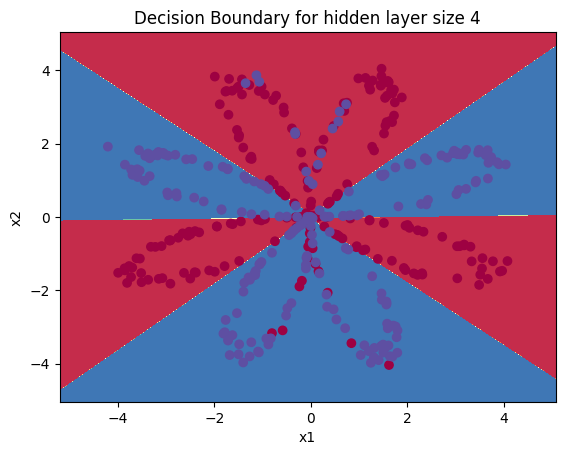

In [103]:
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

### 다른 데이터셋 적용해보기

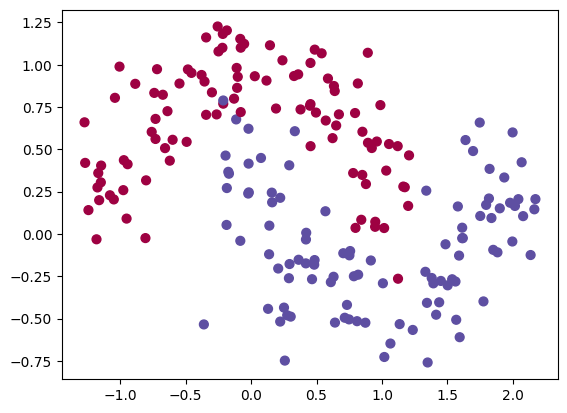

In [104]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "noisy_moons"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

**References**:

- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/